## Week 3 Assignment

#### Task

In the course material, a simple convolutional neural network is built, trained and tested to solve the multiclass classification task presented by the CIFAR-10 dataset. To improve the accuracy, you should experiment with pre trained models. Follow the instructions in Chollet's book "Deep Learning with Python", 2nd edition, Chapter 8, pp. 225-231: Feature extraction with a pre trained model. Pick one of the pre trained models available with Keras, and discard the Dense classifier top. You should only use the convolution base to preprocess the original images to a new representation, using its predict method. For this modified input data, you should build a simple fully connected classifier, train it, and test it.



In [1]:
from keras.datasets import cifar10
import numpy as np
import os
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=77)



#### Model Creation and Image processing

In [ ]:
from keras.layers import Resizing
from keras.applications.vgg16 import preprocess_input
from keras.applications import VGG16


# Define feature extractor
base_model = VGG16(include_top=False, weights="imagenet")
base_model.trainable = False

# Define a batch processing
def process_images_in_batches(images, labels, batch_size=32):
    resize_layer = Resizing(224, 224)
    features_list = []
    total_batches = len(images) // batch_size + (1 if len(images) % batch_size > 0 else 0)
    
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size].astype('float32')
        
        # Resize
        batch_resized = resize_layer(batch_images)
        
        # Preprocess for VGG16
        batch_preprocessed = preprocess_input(batch_resized)
        
        # Extract features
        batch_features = base_model.predict(batch_preprocessed, verbose=1)
        
        # Flatten features
        batch_features_flat = batch_features.reshape(batch_features.shape[0], -1)
        features_list.append(batch_features_flat)
        
        print(f"Processed batch {i//batch_size + 1}/{total_batches}")
    
    # Concatenate all batches
    features = np.concatenate(features_list)
    return features, labels


# Process training, validation and test data
print("Processing training data...")
train_features, train_labels = process_images_in_batches(x_train, y_train)
print("Processing validation data...")
val_features, val_labels = process_images_in_batches(x_val, y_val)
print("Processing test data...")
test_features, test_labels = process_images_in_batches(x_test, y_test)

# Print shapes to confirm processing worked
print(f"Train features shape: {train_features.shape}, labels shape: {train_labels.shape}")
print(f"Validation features shape: {val_features.shape}, labels shape: {val_labels.shape}")
print(f"Test features shape: {test_features.shape}, labels shape: {test_labels.shape}")

#### Save features

In [ ]:

# Add this code cell after your feature extraction code

# Create a directory to save features
os.makedirs("saved_features", exist_ok=True)

# Save the processed features
np.save("saved_features/train_features.npy", train_features)
np.save("saved_features/train_labels.npy", train_labels)
np.save("saved_features/val_features.npy", val_features)
np.save("saved_features/val_labels.npy", val_labels)
np.save("saved_features/test_features.npy", test_features)
np.save("saved_features/test_labels.npy", test_labels)

print("Features and labels saved to disk")

#### Load saved features from hard drive

In [6]:
# Check if saved files exist
if os.path.exists("saved_features/train_features.npy"):
    print("Loading saved features...")
    train_features = np.load("saved_features/train_features.npy")
    train_labels = np.load("saved_features/train_labels.npy")
    val_features = np.load("saved_features/val_features.npy")
    val_labels = np.load("saved_features/val_labels.npy")
    test_features = np.load("saved_features/test_features.npy")
    test_labels = np.load("saved_features/test_labels.npy")
    
    print(f"Train features shape: {train_features.shape}, labels shape: {train_labels.shape}")
    print(f"Validation features shape: {val_features.shape}, labels shape: {val_labels.shape}")
    print(f"Test features shape: {test_features.shape}, labels shape: {test_labels.shape}")
else:
    print("No saved features found. Run the feature extraction first.")

Loading saved features...
Train features shape: (40000, 25088), labels shape: (40000, 1)
Validation features shape: (10000, 25088), labels shape: (10000, 1)
Test features shape: (10000, 25088), labels shape: (10000, 1)


#### Dense layers build

In [7]:
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.optimizers import Adam
from keras import Model

# Define layers
inputs = Input(shape=(train_features.shape[1],))
x = Dense(128, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(10, activation='softmax')(x)

# Add inputs and outputs to model
dense_model = Model(inputs=inputs, outputs=outputs)

# Compile model and print summary
dense_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
dense_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,216,362 (12.27 MB)

 Trainable params: 3,216,106 (12.27 MB)

 Non-trainable params: 256 (1.00 KB)

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical

# Callback functions
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5)



# One-hot encode the labels
train_labels_one_hot = to_categorical(train_labels, num_classes=10)
val_labels_one_hot = to_categorical(val_labels, num_classes=10)

# Train model
history = dense_model.fit(
    train_features, train_labels_one_hot,
    validation_data=(val_features, val_labels_one_hot),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - accuracy: 0.7385 - loss: 0.7931 - val_accuracy: 0.8814 - val_loss: 0.3703 - learning_rate: 0.0010
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - accuracy: 0.8963 - loss: 0.3110 - val_accuracy: 0.8784 - val_loss: 0.3937 - learning_rate: 0.0010
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - accuracy: 0.9257 - loss: 0.2172 - val_accuracy: 0.8837 - val_loss: 0.3838 - learning_rate: 0.0010
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - accuracy: 0.9453 - loss: 0.1636 - val_accuracy: 0.8776 - val_loss: 0.4147 - learning_rate: 0.0010
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - accuracy: 0.9549 - loss: 0.1299 - val_accuracy: 0.8790 - val_loss: 0.4686 - learning_rate: 0.0010
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - accuracy: 0.9619 - loss: 0.1118 - val_accuracy: 0.8824 - val_loss: 0.4545 - learning_rate: 0.0010
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - accura

#### Evaluation and Statistics

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8683 - loss: 0.3855
Feature extractor model test loss: 0.38
Feature extractor model test accuracy: 0.87


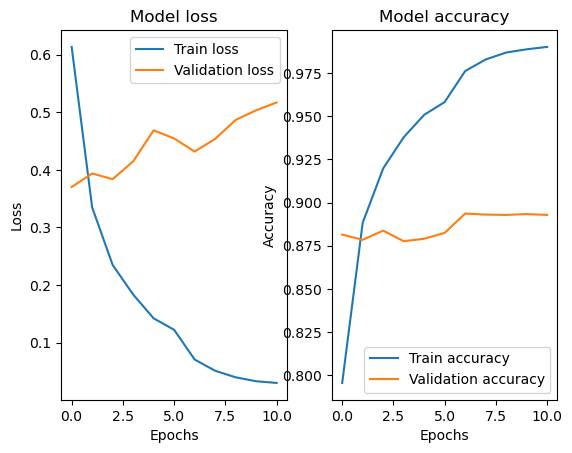

In [9]:
import matplotlib.pyplot as plt

# Plot loss graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# One hot encode test labels
test_labels_one_hot = to_categorical(test_labels, num_classes=10)


# Test model with test data
test_loss, test_acc = dense_model.evaluate(test_features, test_labels_one_hot, verbose=1)
print(f"Feature extractor model test loss: {test_loss:.2f}")
print(f"Feature extractor model test accuracy: {test_acc:.2f}")

#### Summary

I chose VGG16 pre trained model for my base model to this assignment, because it is top 5 model in accuracy and it has ~138 million parameters and relatively small inference time per step when calculated with CPU (69.5 ms).

- First test gave me test loss of 0.55 and test accuracy of 85% with two Dense layers using relu and two Dropout layers.
- Second test gave me test loss of 0.38 and test accuracy of 88%. I only added Batchnormalization layer to Dense model.
- In third test I tried to up Dropout from 0.1 and 0.2 to 0.3 and 0.2, test gave me scores of test lost 0.3907 and test accuracy 87.31%.
- Fourth test gave me test loss of 0.3855  and test accuracy of 87%. I changed neurons from 64 in first Dense layer to 128 neurons.

Already with basic dense layer this model was performing quite good and with couple of small tweaks here and there I got model to perform even better. I could adjust it more to try to get model test accuracy to hit 90% mark, but that would take some time that I think it is not the meaning of this assignment.